# **Modelling and Evaluation Notebook**

## Objectives

*   Answer business requirement 2: 
    * The client wants to be able to predict whether a cherry leaf is healthy or contains powdery mildew.


## Inputs

* inputs/cherry-leaves/cherry-leaves/train
* inputs/cherry-leaves/cherry-leaves/test
* inputs/cherry-leaves/cherry-leaves/validation
* image shape embeddings.

## Outputs
* Images distribution plot in train, validation, and test set.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Machine learning model creation and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.




## Additional Comments | Insights | Conclusions

* No additional comments.  -- come back to this


---

# Set Data Directory

---

## Import libraries

In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

## Set working directory

In [26]:
cwd= os.getcwd()

In [27]:
os.chdir('/workspace/milestone-project-mildew-detection-in-cherry-leaves')
print("Changing directory")

Changing directory


In [28]:
work_dir = os.getcwd()
work_dir

'/workspace/milestone-project-mildew-detection-in-cherry-leaves'

---

## Set input directories

Set train, validation and test paths.

In [29]:
my_data_dir = 'inputs/cherry-leaves/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

In [30]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


### Set label names

In [31]:
# Set the labels
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['healthy', 'powdery_mildew']


---

## Image shape 

In [32]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(175, 175, 3)

---

# Number of images in train, test and validation data

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images


* validation - healthy: 210 images
* validation - powdery_mildew: 210 images


* test - healthy: 422 images
* test - powdery_mildew: 422 images




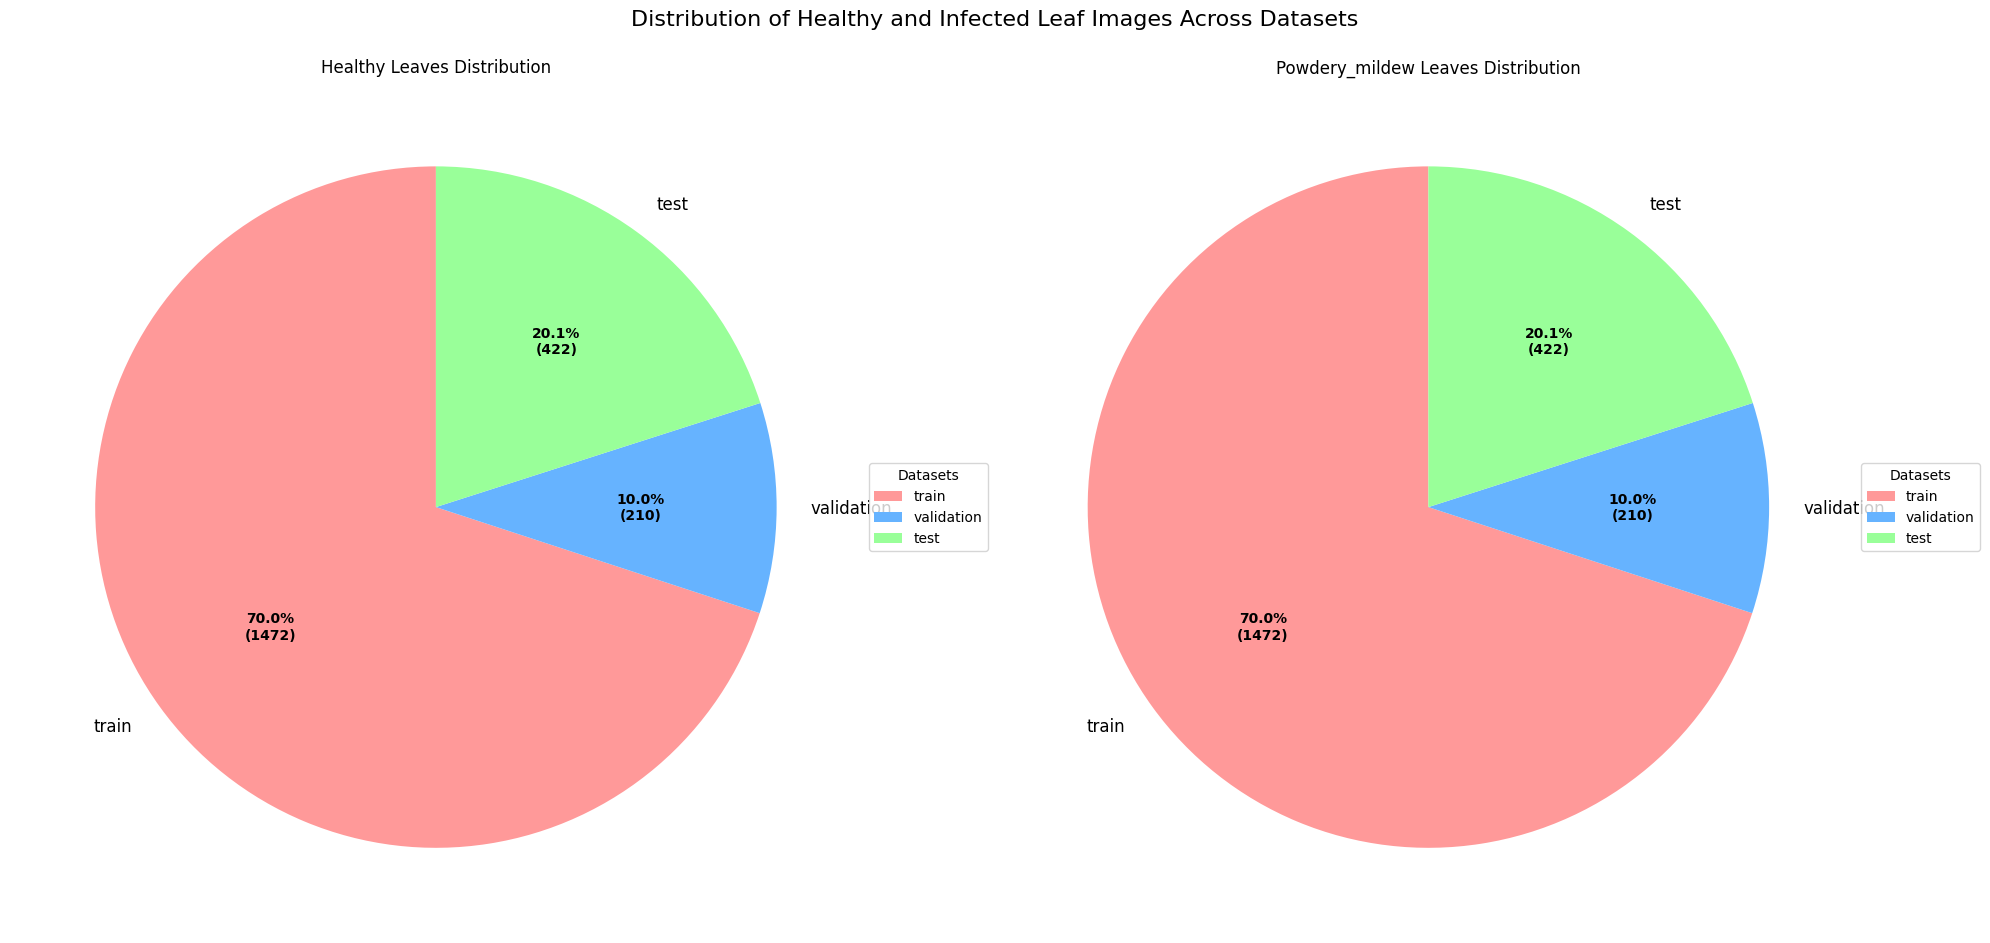

In [33]:
# Create DataFrame to store the frequencies
df_freq = pd.DataFrame([])

# Populate the DataFrame with the count of images
for folder in ['train', 'validation', 'test']:
    for label in ['healthy', 'powdery_mildew']:
        count = len(os.listdir(os.path.join(my_data_dir, folder, label)))
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder, 'Label': label, 'Frequency': int(count)}),
            ignore_index=True
        )
        print(f"* {folder} - {label}: {count} images")
    print("\n")

# Create pie charts for healthy and infected sets
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return f'{pct:.1f}%\n({val:d})'
    return my_autopct

# Pie charts
for label, ax in zip(['healthy', 'powdery_mildew'], axes):
    data = df_freq[df_freq['Label'] == label]
    if data['Frequency'].sum() > 0:
        wedges, texts, autotexts = ax.pie(data['Frequency'], labels=data['Set'], 
                                          autopct=make_autopct(data['Frequency']), 
                                          startangle=90,
                                          colors=['#ff9999','#66b3ff','#99ff99'])
        ax.set_title(f'{label.capitalize()} Leaves Distribution')
        
        # Enhance the legend
        ax.legend(wedges, data['Set'],
                  title="Datasets",
                  loc="center left",
                  bbox_to_anchor=(1, 0, 0.5, 1))
        
        # Styling
        plt.setp(autotexts, size=10, weight="bold")
        plt.setp(texts, size=12)
    else:
        ax.text(0.5, 0.5, f'No data for {label}', ha='center', va='center')
        ax.axis('off')

plt.suptitle("Distribution of Healthy and Infected Leaf Images Across Datasets", fontsize=16)
plt.tight_layout()
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

---

# Image data augmentation

---

### ImageDataGenerator

In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

* ### Initialize ImageDataGenerator

In [35]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )


* ### Augment training image dataset

In [36]:
batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices


Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* ### Augment validation image dataset

In [37]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices


Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* ### Augment test image dataset

In [38]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices


Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Plot augmented training image

(20, 175, 175, 3)


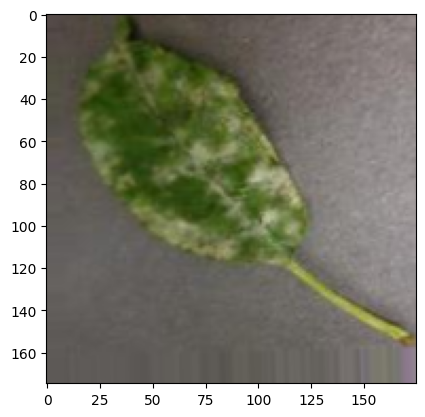

(20, 175, 175, 3)


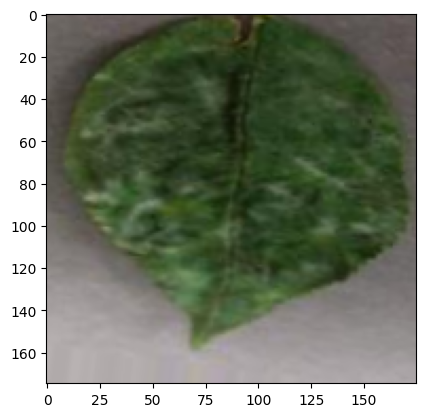

(20, 175, 175, 3)


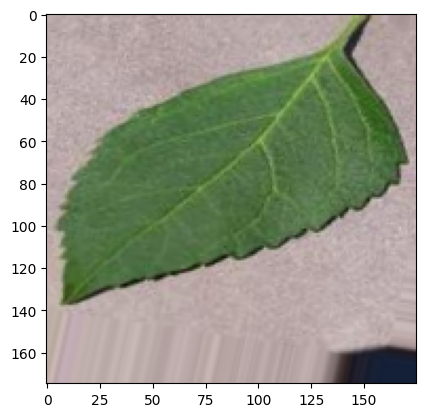

In [39]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()


## Plot augmented validation and test images

(20, 175, 175, 3)


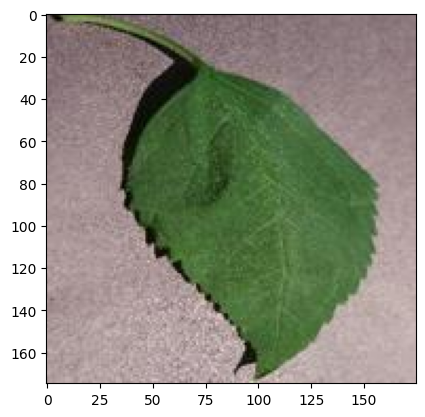

(20, 175, 175, 3)


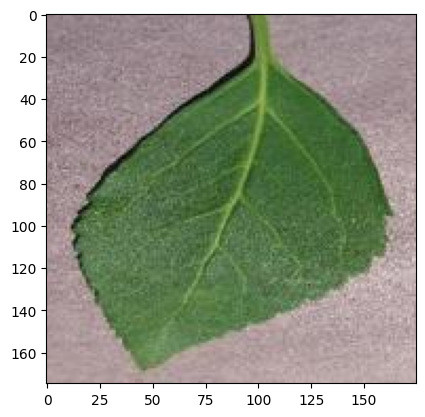

(20, 175, 175, 3)


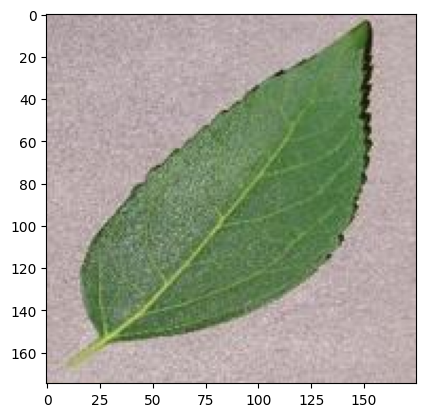

In [40]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()


(20, 175, 175, 3)


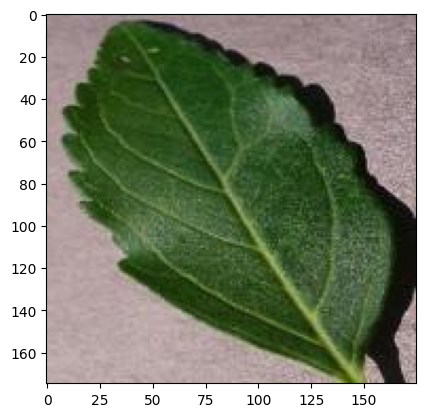

(20, 175, 175, 3)


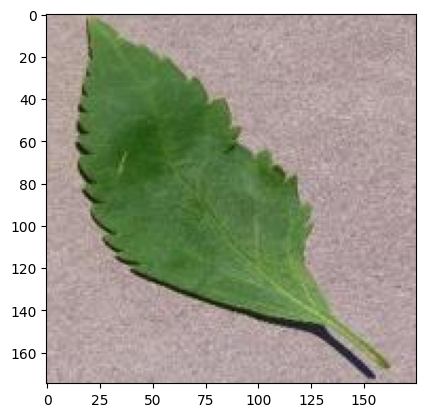

(20, 175, 175, 3)


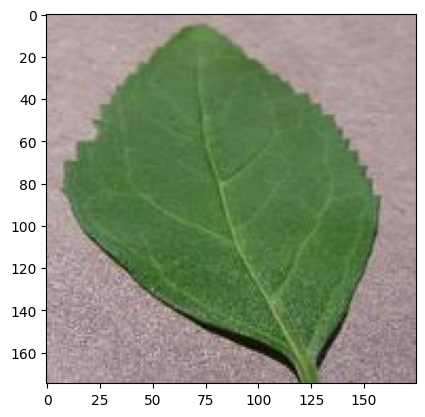

In [41]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()


## Save class_indices

In [42]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")


['outputs/v1/class_indices.pkl']

---

# Model creation

---

## ML model

* ### Import model packages

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

* ### Model 

In [44]:

def create_tf_model(image_shape=(175, 175, 3)):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model


* ### Model Summary 

In [45]:
model = create_tf_model(image_shape=(175, 175, 3))

* ### Early Stopping 

In [46]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)


## Fit model for model training

In [47]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )


Epoch 1/25
147/147 [==============================] - 149s 1s/step - loss: 0.2303 - accuracy: 0.8947 - val_loss: 0.0657 - val_accuracy: 0.9738
Epoch 2/25
147/147 [==============================] - 147s 997ms/step - loss: 0.0558 - accuracy: 0.9826 - val_loss: 0.0296 - val_accuracy: 0.9952
Epoch 3/25
147/147 [==============================] - 130s 886ms/step - loss: 0.0425 - accuracy: 0.9867 - val_loss: 0.0201 - val_accuracy: 0.9976
Epoch 4/25
147/147 [==============================] - 132s 896ms/step - loss: 0.0270 - accuracy: 0.9918 - val_loss: 0.0251 - val_accuracy: 0.9976
Epoch 5/25
147/147 [==============================] - 131s 894ms/step - loss: 0.0284 - accuracy: 0.9908 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 6/25
147/147 [==============================] - 132s 900ms/step - loss: 0.0208 - accuracy: 0.9928 - val_loss: 0.0108 - val_accuracy: 0.9976
Epoch 7/25
147/147 [==============================] - 130s 886ms/step - loss: 0.0120 - accuracy: 0.9962 - val_loss: 0.0154 - va

## Save model

In [48]:
model.save('outputs/v1/cherry-leaves_model.h5')

---

# Model Performace

---

## Model learning curve

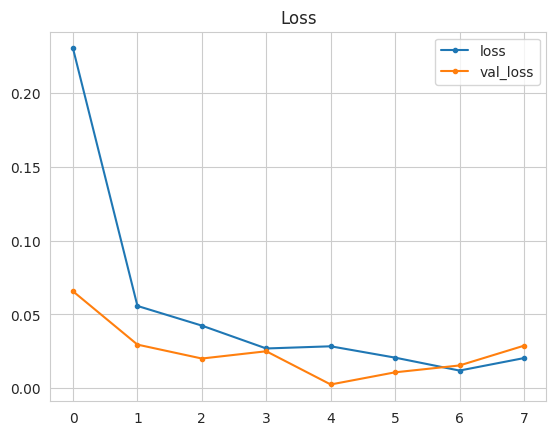

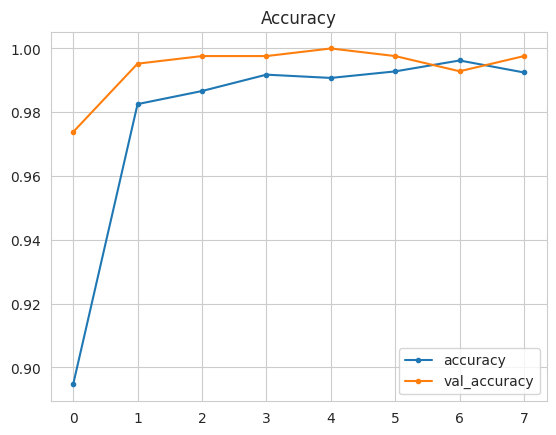

In [49]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()


## Model learning curve continued

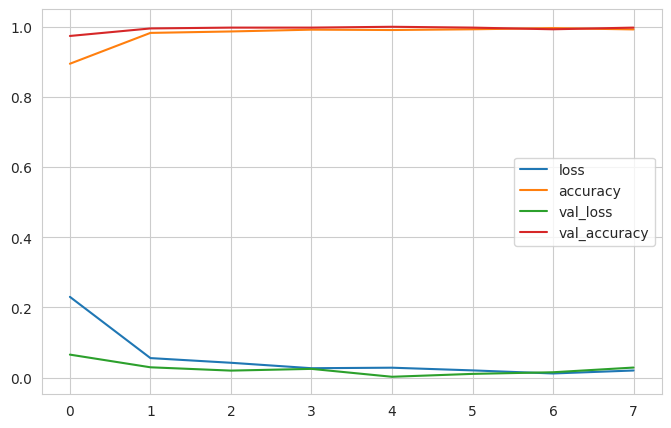

In [50]:
pd.DataFrame(model.history.history).plot(figsize=(8,5))

plt.savefig(f'{file_path}/model_loss_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Model Evaluation

Load saved model

In [51]:
from keras.models import load_model
model = load_model('outputs/v1/cherry-leaves_model.h5')

Evaluate model on test set

In [52]:
evaluation = model.evaluate(test_set)


43/43 [==============================] - 8s 195ms/step - loss: 7.6900e-04 - accuracy: 1.0000


### Save evaluation pickle

In [53]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")


['outputs/v1/evaluation.pkl']

## Predict on new data

Load a random image as PIL

Image shape: (175, 175), Image mode: RGB


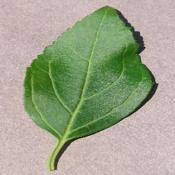

In [54]:
from tensorflow.keras.preprocessing import image

pointer = 66
label = labels[0]  # select clean or mildewed

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image



Convert image to array and prepare for prediction

In [55]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 175, 175, 3)


Predict class probabilities

In [56]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)


0.9999914950230959
healthy


## Confusion Matrix and classification report

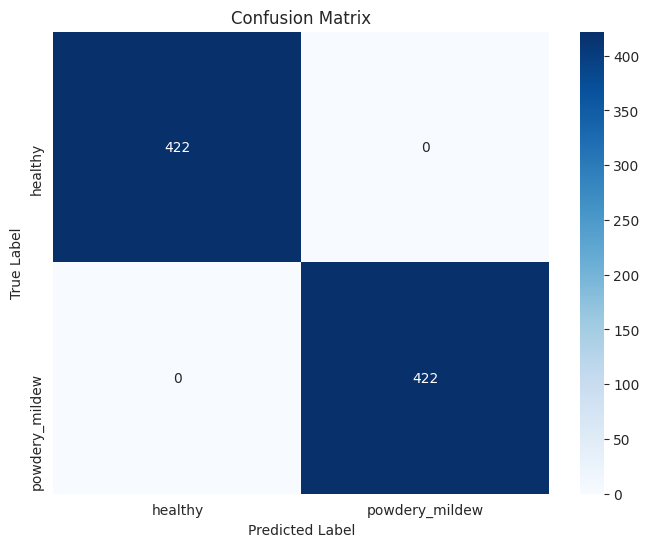

                precision    recall  f1-score   support

       healthy       1.00      1.00      1.00       422
powdery_mildew       1.00      1.00      1.00       422

      accuracy                           1.00       844
     macro avg       1.00      1.00      1.00       844
  weighted avg       1.00      1.00      1.00       844

Confusion matrix saved to outputs/v1/confusion_matrix.png
Classification report saved to outputs/v1/classification_report.txt


In [57]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing import image

# Make Predictions for All Test Images
true_labels = []
pred_labels = []

# Ensure test_set is your test data generator
for label in test_set.class_indices:
    class_dir = os.path.join(test_path, label)
    for img_file in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_file)
        pil_image = image.load_img(img_path, target_size=image_shape, color_mode='rgb')
        
        my_image = image.img_to_array(pil_image)
        my_image = np.expand_dims(my_image, axis=0) / 255
        
        pred_proba = model.predict(my_image)[0, 0]
        pred_class = 1 if pred_proba > 0.5 else 0  # 1 for 'mildewed', 0 for 'clean'
        
        true_class = test_set.class_indices[label]
        
        true_labels.append(true_class)
        pred_labels.append(pred_class)

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

# Generate Confusion Matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(test_set.class_indices.keys()), yticklabels=list(test_set.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Save the confusion matrix plot
conf_matrix_plot_path = os.path.join(file_path, 'confusion_matrix.png')
plt.savefig(conf_matrix_plot_path, bbox_inches='tight', dpi=150)
plt.show()

# Generate Classification Report
class_report = classification_report(true_labels, pred_labels, target_names=list(test_set.class_indices.keys()))

# Print the classification report to the console
print(class_report)

# Save the classification report to a text file
class_report_path = os.path.join(file_path, 'classification_report.txt')
with open(class_report_path, 'w') as f:
    f.write(class_report)

print(f'Confusion matrix saved to {conf_matrix_plot_path}')
print(f'Classification report saved to {class_report_path}')

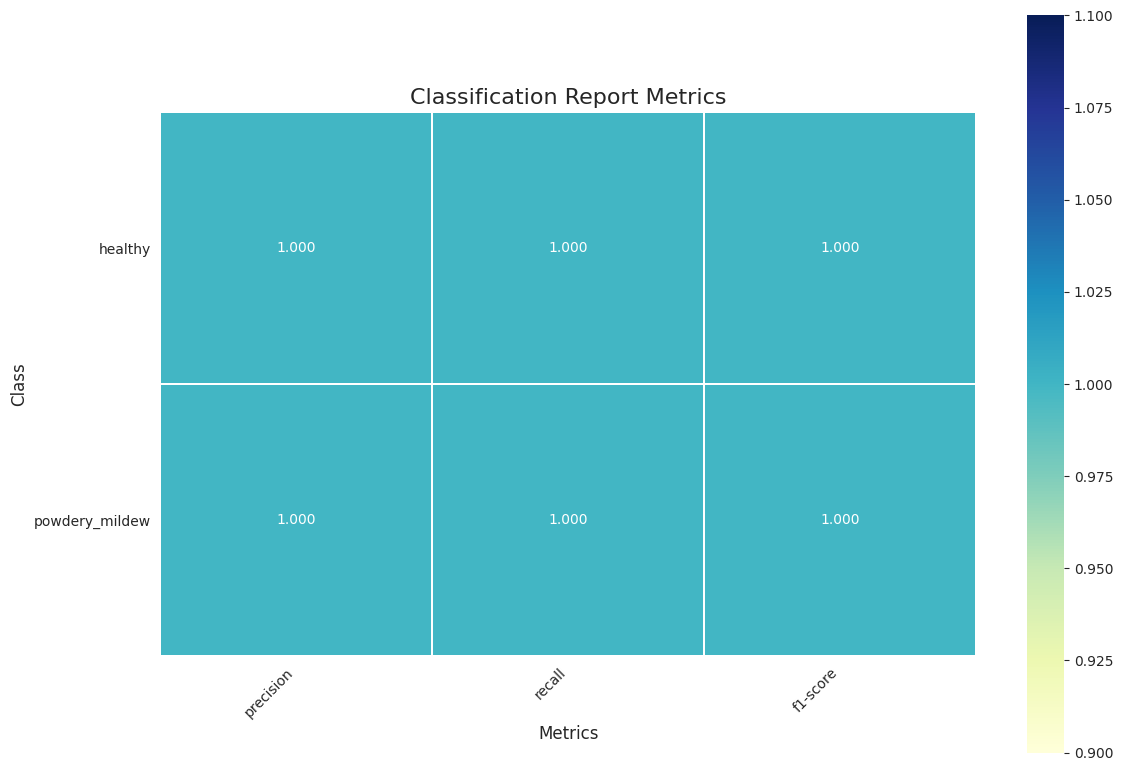

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import pandas as pd

# Generate Classification Report
class_report = classification_report(true_labels, pred_labels, target_names=list(test_set.class_indices.keys()), output_dict=True)

# Extract metrics for each class
class_names = list(test_set.class_indices.keys())
metrics = ['precision', 'recall', 'f1-score']
class_metrics = {metric: [class_report[class_name][metric] for class_name in class_names] for metric in metrics}

# Convert to DataFrame for easier plotting
metrics_df = pd.DataFrame(class_metrics, index=class_names)

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(metrics_df, annot=True, cmap='YlGnBu', fmt=".3f", cbar=True, square=True, linewidths=0.5)
plt.title('Classification Report Metrics', fontsize=16)
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Class', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Save the figure
plt.savefig('classification_report_heatmap.png', bbox_inches='tight', dpi=300)

# Display the plot
plt.show()

---

# Push files to Repo

## Push generated/new files from this Session to your GitHub repo

* Git add

In [59]:
!git add .

* Git commit

In [ ]:
!git commit -am "Modelling and evaluation notebook"

[main 08db32a] Modelling and evaluation notebook
 1959 files changed, 208 insertions(+), 40 deletions(-)
 create mode 100644 boxplot_distribution.png
 create mode 100644 classification_report_heatmap.png
 rename inputs/cherry-leaves/cherry-leaves/{train => test}/healthy/0008f3d3-2f85-4973-be9a-1b520b8b59fc___JR_HL 4092.JPG (100%)
 rename inputs/cherry-leaves/cherry-leaves/{train => test}/healthy/0008f3d3-2f85-4973-be9a-1b520b8b59fc___JR_HL 4092_180deg.JPG (100%)
 rename inputs/cherry-leaves/cherry-leaves/{train => test}/healthy/002efba9-09b3-43de-93b7-5c2460185cde___JR_HL 9655.JPG (100%)
 rename inputs/cherry-leaves/cherry-leaves/{train => test}/healthy/0048afb8-b950-4c57-9e72-7e26282327ee___JR_HL 9765.JPG (100%)
 rename inputs/cherry-leaves/cherry-leaves/{train => test}/healthy/011f07d1-8813-4a63-99c7-e274ab5cc261___JR_HL 4165_180deg.JPG (100%)
 rename inputs/cherry-leaves/cherry-leaves/{train => test}/healthy/014161fb-3c15-414b-9af3-00cb51a11d7c___JR_HL 9842_180deg.JPG (100%)
 rename

* Git Push

In [ ]:
!git push

Enumerating objects: 39, done.
Counting objects: 100% (39/39), done.
Delta compression using up to 32 threads
Compressing objects: 100% (21/21), done.
Writing objects: 100% (24/24), 518.34 KiB | 6.91 MiB/s, done.
Total 24 (delta 6), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (6/6), completed with 6 local objects.
To https://github.com/Swewi/milestone-project-mildew-detection-in-cherry-leaves.git
   1096d11..08db32a  main -> main
